## Sales forecasting with EXPERT

We focus on forecasting monthly revenues per country, prioritizing the regions most critical to our business while including global revenues for broader insights. We incorporate macroeconomic indicators like business and consumer confidence indicators for specific regions, relevant to our most important market. These indicators are known to anticipate market shifts before they appear in our sales data, improving forecast reliability and model accuracy.

In [79]:
from futureexpert import *
import futureexpert.checkin as checkin

client = ExpertClient()

INFO:futureexpert.expert_client:Successfully logged in for group group-expert.


## CHECK-IN configuration
In this step, we transform our CSV data into structured time series. First, we define the data structure. For each column, we specify whether it contains the date, grouping information (in our case hierarchical information about the sales regions), or value data. 
During the time series creation process, we choose to aggregate the data at the “Country” level, creating one time series per country. To align with current business operations, we exclude data prior to March 2016 to account for changes caused by past organizational restructuring. If our data contains missing values, we leverage FORECAST’s ability to find adequate replacement values by setting the `missing_value_handler` to `keepNaN`.
Our covariates are stored in a separate file with a nearly identical format, simplifying the configuration process.


In [97]:
# check in consumptions
ts_check_in_results = client.check_in_time_series(raw_data_source='sales_data.csv',
                                                  data_definition=DataDefinition(date_columns=checkin.DateColumn(name='Date', format='%d.%m.%Y'),
                                                                                 value_columns=[checkin.ValueColumn(name='Sales')],
                                                                                 group_columns=[checkin.GroupColumn(name='Region'),
                                                                                                checkin.GroupColumn(name='Country'),
                                                                                                checkin.GroupColumn(name='SubregionCode')]),
                                                  config_ts_creation=TsCreationConfig(time_granularity='monthly',
                                                                                      start_date="2016-03-01",
                                                                                      value_columns_to_save=['Sales'],
                                                                                      grouping_level=["Country"],
                                                                                      missing_value_handler="keepNaN",),
                                                  file_specification=FileSpecification(delimiter=';', decimal='.'))

INFO:futureexpert.expert_client:Transforming input data...
INFO:futureexpert.expert_client:Creating time series using CHECK-IN...
INFO:futureexpert.expert_client:Finished time series creation.


In [98]:
# check in indicators
relevant_inds = ['Germany..Consumer.confidence.index','Global..Consumer.confidence.index','Europe..Consumer.confidence.index','Global..Business.confidence.index','Europe..Business.confidence.index','Germany..Business.confidence.index']
covs_check_in_results = client.check_in_time_series(raw_data_source='sales_covariates.csv',
                                                    data_definition=DataDefinition(date_columns=checkin.DateColumn(name='Date', format='%Y-%m-%d'),
                                                                                   value_columns=[
                                                                                       checkin.ValueColumn(name='Values')],
                                                                                   group_columns=[checkin.GroupColumn(name="Indicator")]),
                                                    config_ts_creation=TsCreationConfig(time_granularity='monthly',
                                                                                        value_columns_to_save=['Values'],
                                                                                        grouping_level=["Indicator"],
                                                                                        missing_value_handler="keepNaN",
                                                                                        start_date="2015-01-01",
                                                                                        end_date="2024-05-01",
                                                                                        filter=[FilterSettings(type='inclusion', items=relevant_inds, variable='Indicator')]),

                                                    file_specification=FileSpecification(delimiter=';', decimal='.'))

INFO:futureexpert.expert_client:Transforming input data...
INFO:futureexpert.expert_client:Creating time series using CHECK-IN...
INFO:futureexpert.expert_client:Finished time series creation.


## Use MATCHER to find the best covariates
The relationships between covariates and individual country sales are complex, and the regions may not necessarily align with one another. Additionally, the temporal relationship needs to be identified. MATCHER helps us discover these relations by requiring only the IDs of our two sets of time series (sales and covariates). Given our understanding of the temporal relationship, we rely on the sensible default setting for the lags so that all lags between -2 and 6 are tested.

Note: The covariates in this notebook are stored in a CSV file, but they can also be accessed from the factor database POOL which is regularly updated. You can even use a combination of factors from POOL and your own CSV file. For more details how to use it, see the using covariates from 
[POOL Notebook](../notebooks/using_covariates_from_POOL.ipynb).

In [99]:
# perform cov selection
config_matcher = MatcherConfig(title='Indicator selection for sales data',
                               actuals_version=ts_check_in_results.version_id,
                               covs_versions=[covs_check_in_results.version_id],
                               lag_selection=LagSelectionConfig(min_lag=-2, max_lag=6))

matcher_identifier = client.start_matcher(config=config_matcher)

import time

# Watch the current status of the matcher report
while not (current_status := client.get_report_status(id=matcher_identifier, include_error_reason=True)).is_finished:
    time.sleep(60)  # Wait between status requests
    current_status.print()

current_status.print()

matcher_results = client.get_matcher_results(matcher_identifier)

INFO:futureexpert.expert_client:Finished report creation.


Status forecasting report for id: report_id=44708 settings_id=44721
 0 % are finished 
 8 time series requested for calculation 
 0 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Status forecasting report for id: report_id=44708 settings_id=44721
 100 % are finished 
 8 time series requested for calculation 
 8 time series finished 
 0 time series without evaluation 
 0 time series ran into an error


### Matcher results
Let’s have a look into the results. For each time series, we find a ranked list of covariates. Only leading covariates are included in the results. A covariate is considered "leading" if, after applying the selected lag, it provides at least one data point for the forecasted months. If we were interested in these covariates, we could simply set the parameter `enable_leading_covariate_selection` to False.
In our case, half the time series benefit from using indicators. For France, Austria, Spain and the global data the model without a covariate performs better. German indicators perform well for many major European countries, while the models for the U.S. sales benefit from the broader scope of global indicators.

In [86]:
matcher_results = client.get_matcher_results(matcher_identifier)
for ts_result in sorted(matcher_results, key=lambda x: x.actuals.name):
    print(ts_result.actuals.name)
    for r in sorted(ts_result.ranking, key=lambda x: x.rank):
        if covs := r.covariates:
            print(f'\t rank: {r.rank} {covs[0].ts.name}')
        else:
            print(f'\t rank: {r.rank} no cov')

Sales-Austria
	 rank: 1 no cov
	 rank: 2 VALUES-Germany..Consumer.confidence.index
	 rank: 3 VALUES-Europe..Consumer.confidence.index
	 rank: 4 VALUES-Europe..Business.confidence.index
	 rank: 5 VALUES-Germany..Business.confidence.index
	 rank: 6 VALUES-Global..Consumer.confidence.index
	 rank: 7 VALUES-Global..Business.confidence.index
Sales-France
	 rank: 1 no cov
	 rank: 2 VALUES-Global..Consumer.confidence.index
	 rank: 3 VALUES-Europe..Consumer.confidence.index
	 rank: 4 VALUES-Germany..Consumer.confidence.index
Sales-Germany
	 rank: 1 VALUES-Germany..Consumer.confidence.index
	 rank: 2 VALUES-Europe..Consumer.confidence.index
	 rank: 3 VALUES-Global..Consumer.confidence.index
	 rank: 4 VALUES-Germany..Business.confidence.index
	 rank: 5 VALUES-Europe..Business.confidence.index
	 rank: 6 VALUES-Global..Business.confidence.index
	 rank: 7 no cov
Sales-Global
	 rank: 1 no cov
	 rank: 2 VALUES-Europe..Consumer.confidence.index
	 rank: 3 VALUES-Global..Consumer.confidence.index
Sales-

## Creation of forecast

With CHECK-IN having prepared our time series and MATCHER identifying the best relationship between the time series and the indicators, we are ready to configure the FORECAST settings:
- We define a set of forecasting methods that have proven effective for us in the past. Reducing the methods to this list accelerates forecast generation. The selection includes both statistical and machine learning methods. While we are aware that classical statistical methods are generally the most suitable for our time series, we still include a few machine learning methods to test their performance.
- By default, forecasts are generated using only one covariate-based method (AutoESCov). To increase the likelihood of achieving the most reliable results, we add “Glmnet” as an additional method that accounts for covariates.
- We also create forecasts using an ensemble, which combines the best performing models. Ensemble strategies are known for their robustness and reliability.
- Our forecast horizon is set to 12 months to align with our planning needs.
- A lower bound of 0 ensures that the forecasts remain non-negative, reflecting our historically positive data history.
- In the method selection configuration, we emphasize the first 3 forecast steps, assigning steps 4-6 half the weight. This ensures the models deliver optimal performance during the most critical forecasting period - the first 6 months.


In [100]:
from futureexpert import *
fc_methods = ['AutoEsCov', 'ExtraTrees','TBATS','LinearRegression','Naive','RandomForest','SVM', 'XGBoost', 'MA(granularity)','MA(3)', 'MA(season lag)', 'Glmnet(l1_ratio=1.0)', 'SVM']
fc_report_config = ReportConfig(title='Monthly Sales Forecast on Country Level',
                                preprocessing=PreprocessingConfig(detect_outliers=True,
                                                                  replace_outliers=True,
                                                                  detect_changepoints=True),
                                forecasting=ForecastingConfig(fc_horizon=12,
                                                              lower_bound=0,
                                                              use_ensemble=True,
                                                              confidence_level=0.90),
                                method_selection=MethodSelectionConfig(number_iterations=12,
                                                                       refit=True,
                                                                       step_weights={1:1., 2:1., 3:1., 4:0.5, 5:0.5, 6:0.5},
                                                                       additional_cov_method='Glmnet(l1_ratio=1.0)',
                                                                       forecasting_methods=fc_methods),
                                matcher_report_id=matcher_identifier.report_id,
                                covs_versions=[covs_check_in_results.version_id])

forecast_identifier = client.start_forecast(version=ts_check_in_results.version_id, config=fc_report_config)
print(forecast_identifier)

INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with FORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


report_id=44709 settings_id=44722


In [101]:

# Watch the current status of the forecasting report
while not (current_status := client.get_report_status(id=forecast_identifier)).is_finished:
    current_status.print()
    time.sleep(60)  # Wait between status requests
# Retrieve the results of the forecasting report
current_status.print()



Status forecasting report for id: report_id=44709 settings_id=44722
 0 % are finished 
 8 time series requested for calculation 
 0 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Status forecasting report for id: report_id=44709 settings_id=44722
 0 % are finished 
 8 time series requested for calculation 
 0 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Status forecasting report for id: report_id=44709 settings_id=44722
 0 % are finished 
 8 time series requested for calculation 
 0 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Status forecasting report for id: report_id=44709 settings_id=44722
 25 % are finished 
 8 time series requested for calculation 
 2 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Status forecasting report for id: report_id=44709 settings_id=44722
 38 % are finished 
 8 time series requeste

In [90]:
results = client.get_fc_results(id=forecast_identifier , include_backtesting=True, include_k_best_models=100)

### Forecast results

The overview table provides a clear summary of the key features of each time series and their best-performing forecasting models:
- As expected, all time series are categorized in the “smooth” class and exhibit a season length of 12, indicating yearly seasonality. Almost all of them show either a global trend or a recent trend.
- The classical statistical method “Exponential Smooting” is ideally suited for smooth time series with typical structures like seasonal patterns and trends. This proprietary development further integrates covariates making it an excellent choice in this case, which is why it has been identified as the best model for half of our regions.
- We see that the Consumer Confidence Index from Europe was used to build the best models for multiple of our time series. While this indicator could not be used for all 12 forecast steps, the “smooth extension strategy” ensures its influence is extended across the entire forecast horizon.

In [91]:
from futureexpert.forecast import export_result_overview_to_pandas
overview = export_result_overview_to_pandas(results)
overview.sort_values(by="name")

,name,Country,model,cov,cov_lag,season_length,ts_class,quantization,trend,recent_trend,missing_values_count,outliers_count
2,Sales-Austria,Austria,Ensemble,NaN,NaN,[12],smooth,NaN,False,True,NaN,NaN
4,Sales-France,France,LinearRegression,NaN,NaN,[12],smooth,NaN,True,True,NaN,NaN
6,Sales-Germany,Germany,AutoEsCov extended by SmoothExtensionStrategy,VALUES-Europe..Consumer.confidence.index,1.0,[12],smooth,NaN,True,True,NaN,NaN
0,Sales-Global,Global,AutoEsCov extended by SmoothExtensionStrategy,VALUES-Europe..Consumer.confidence.index,1.0,[12],smooth,NaN,False,True,NaN,NaN
3,Sales-Italy,Italy,AutoEsCov extended by SmoothExtensionStrategy,VALUES-Europe..Consumer.confidence.index,3.0,[12],smooth,NaN,True,True,NaN,NaN
5,Sales-Poland,Poland,Ensemble,NaN,NaN,[12],smooth,NaN,False,False,NaN,NaN
1,Sales-Spain,Spain,TBATS,NaN,NaN,[12],smooth,NaN,True,True,NaN,NaN
7,Sales-USA,USA,AutoEsCov extended by SmoothExtensionStrategy,VALUES-Global..Consumer.confidence.index,3.0,[12],smooth,NaN,False,False,NaN,NaN


Next, we use the plotting functionality provided by EXPERT to inspect the forecast visuals. By settings `plot_covariates=True`, the plot include a line representing the covariates used in each respective model.

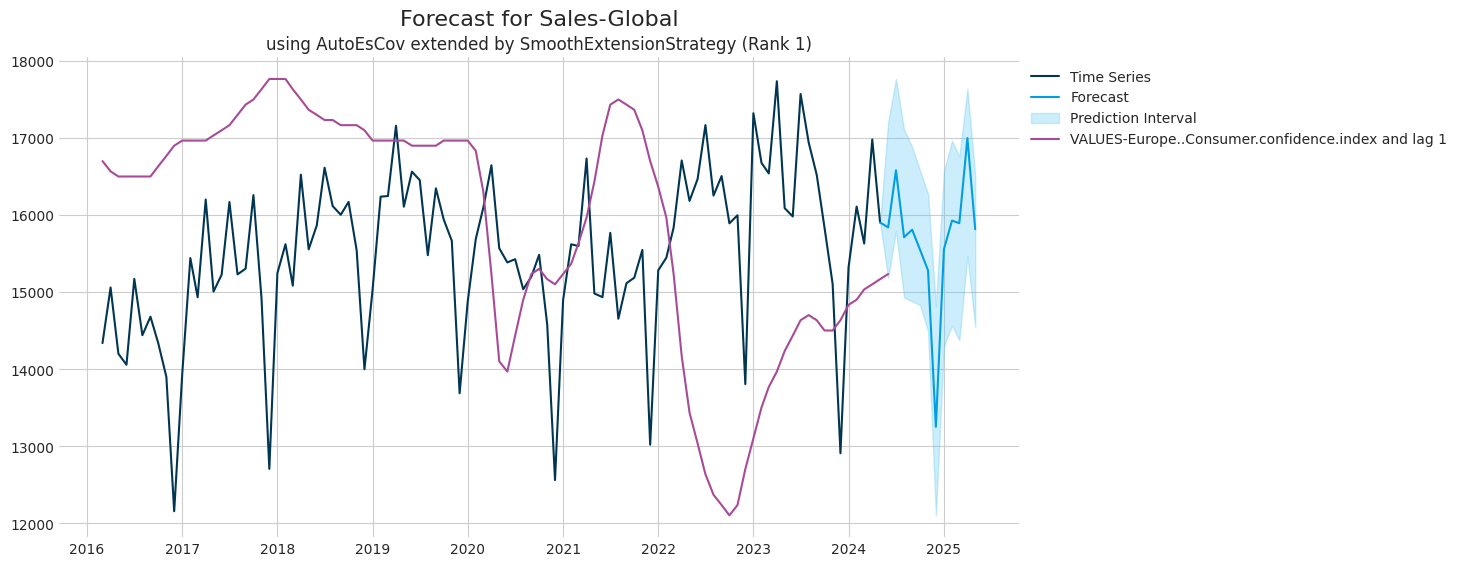

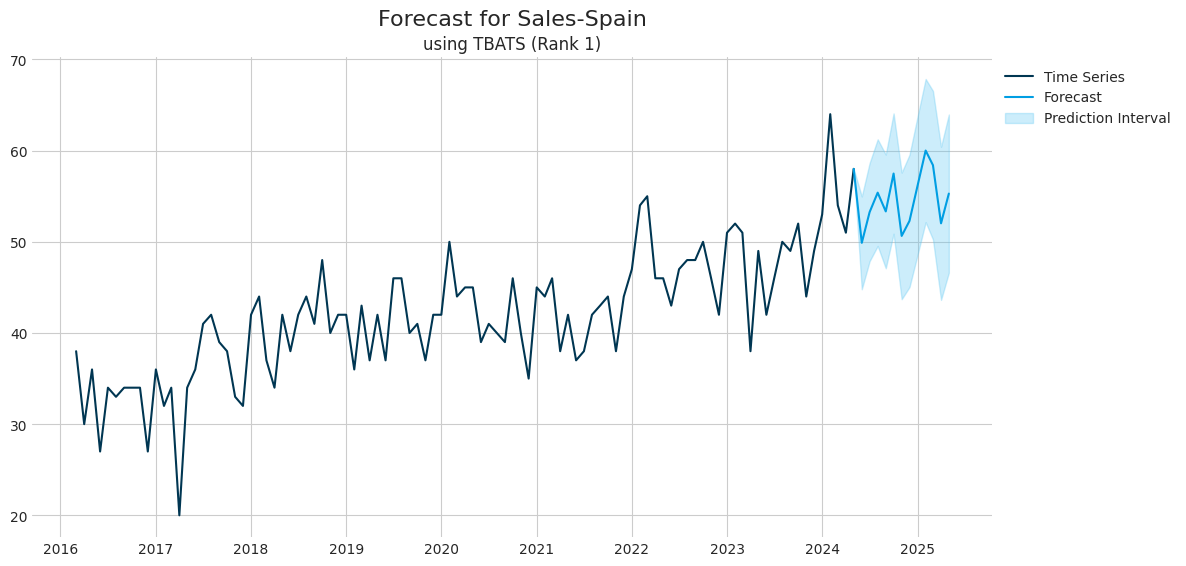

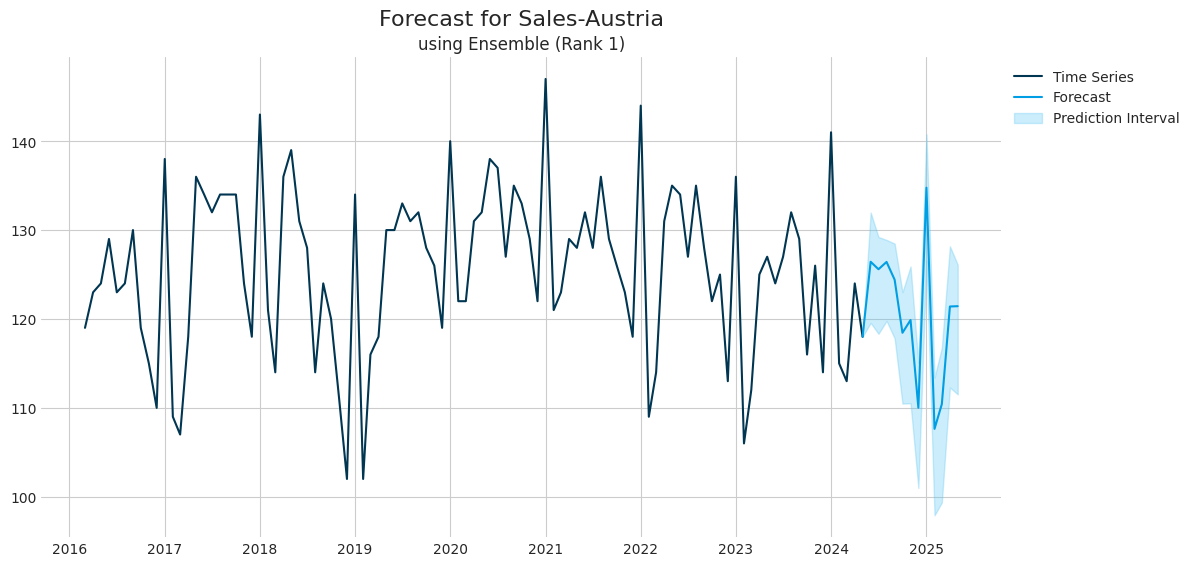

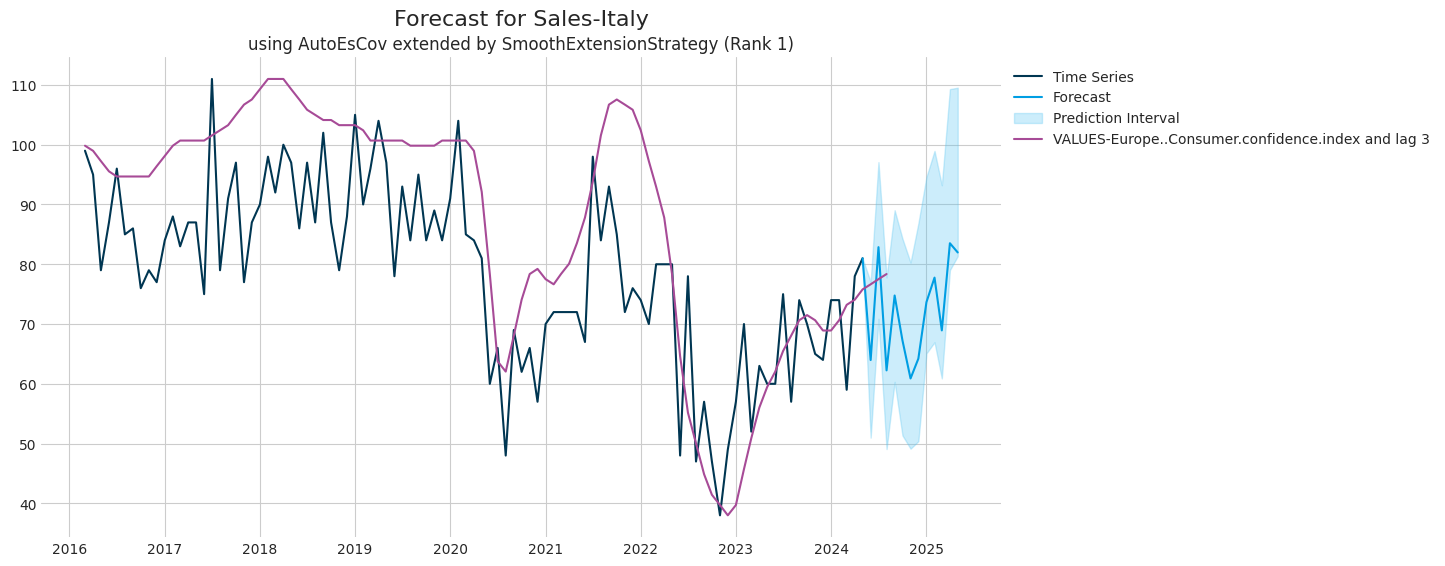

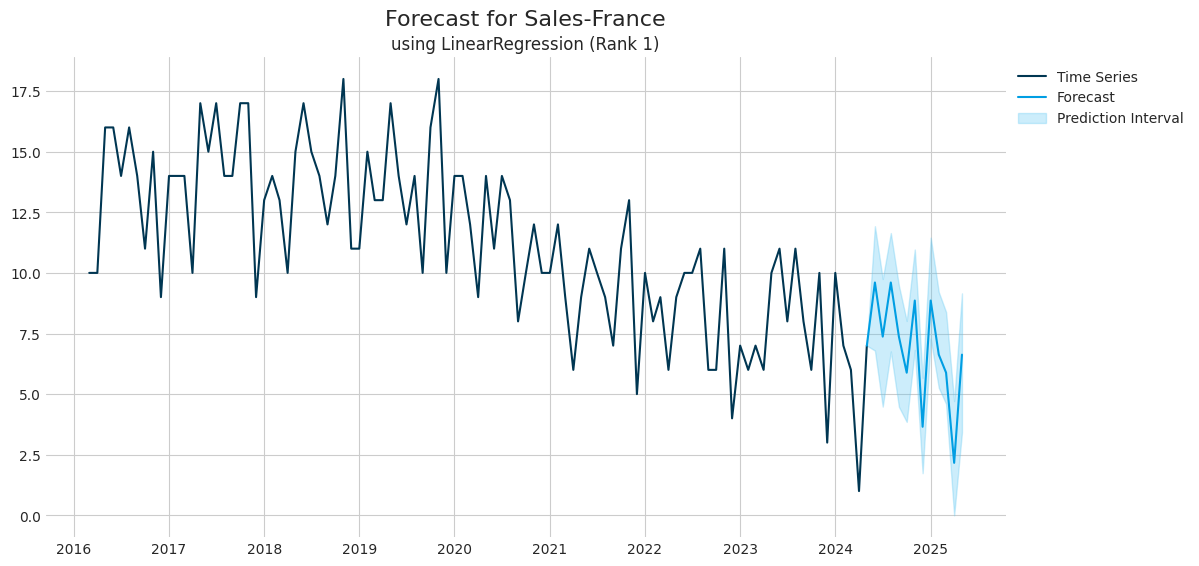

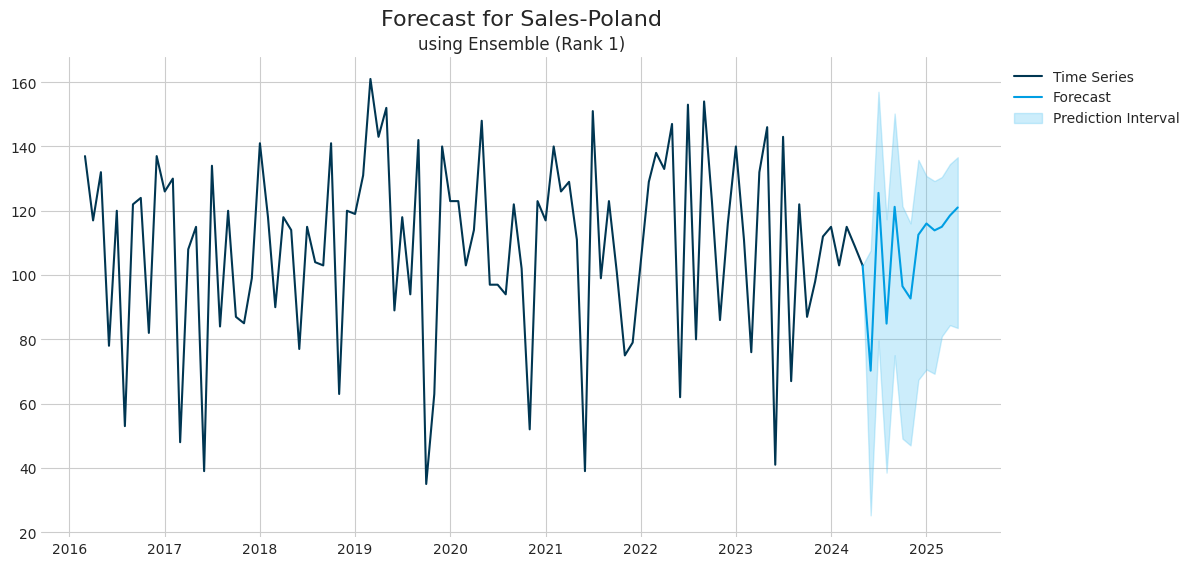

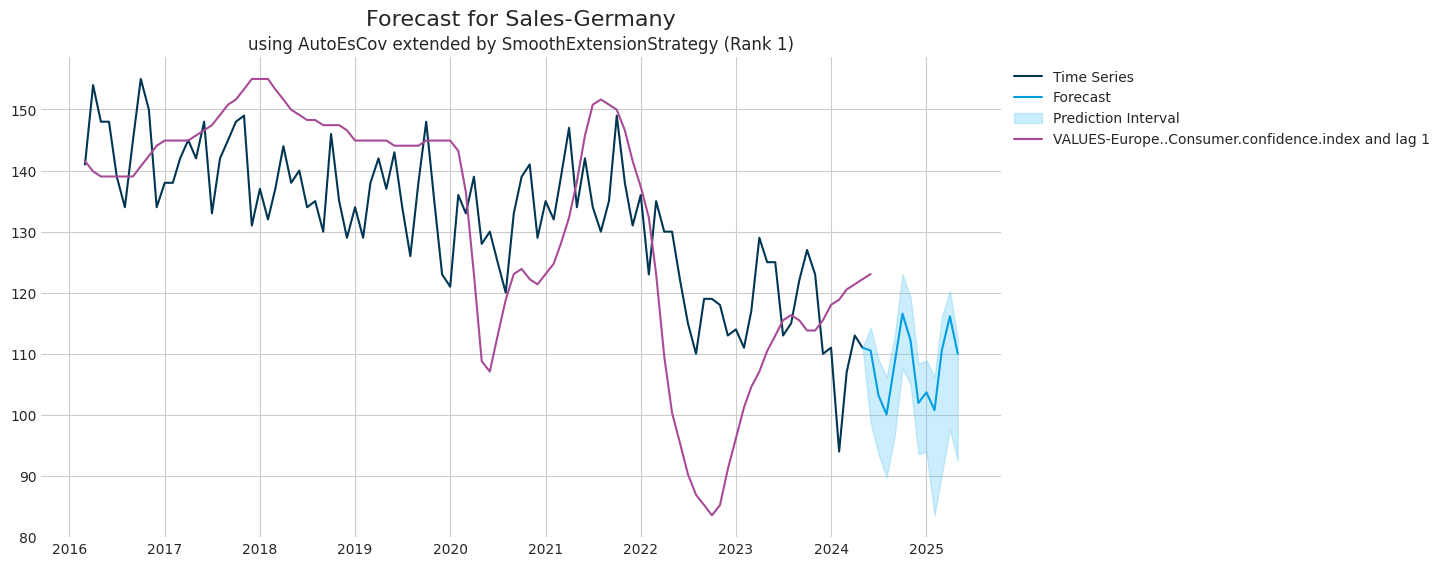

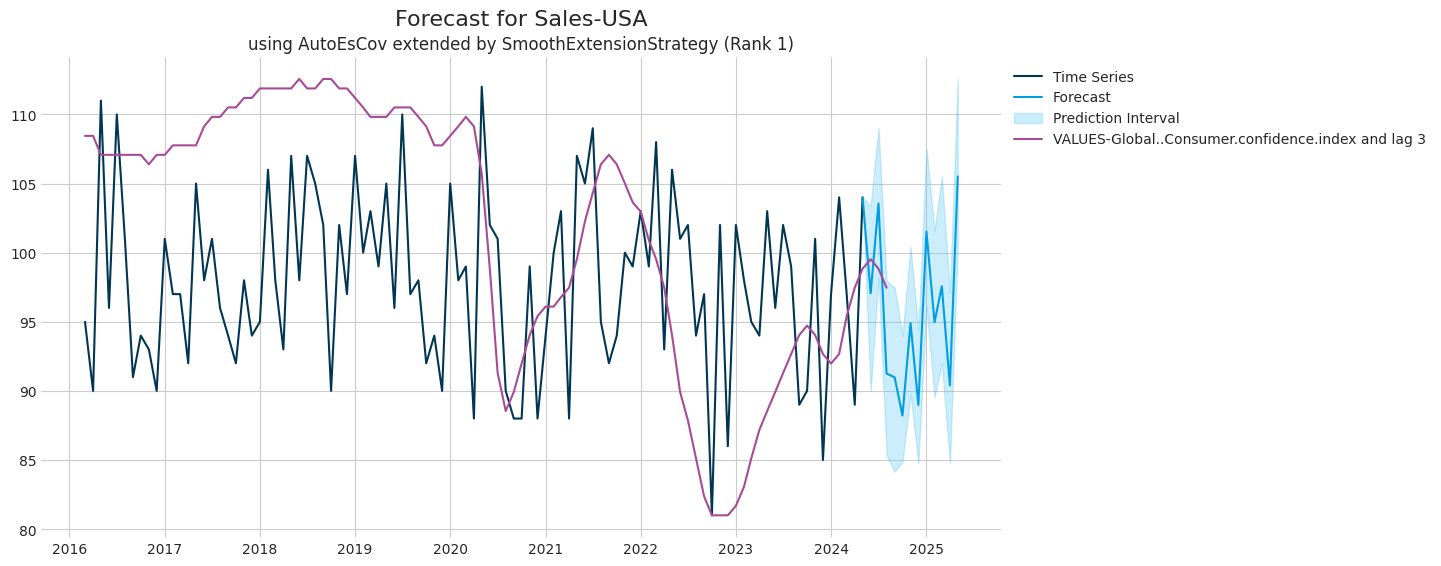

In [96]:
import futureexpert.plot as plot
for ts_result in results:
    plot.plot_forecast(ts_result, plot_outliers=True, ranks=[1], plot_covariates=True)